# Get Started with Resen

Welcome to the Reusable Software Environment (ReSEn) platform!  In this tutorial, we will demonstate how Resen lets you access many common geospace package, allowing you to skip installation and set up and get started on your research immediately.  This is not intended to be a comprehensive introduction to all the packages available in Resen.  Please refer to the [package list](https://ingeo.datatransport.org/home/resen/packages) on the [InGeO website](https://ingeo.datatransport.org/home/) for a complete list of packages in Resen, and documentation of individual pakages for tutorials and full descriptions of their functionality.

## Space science software
Resen gives you the ability to use common community packages.  Let's use pyglow to get an altitude profile of IRI electron densities above PFISR.

In [1]:
from datetime import datetime
import numpy as np
# import pyglow

import matplotlib.pyplot as plt
%matplotlib inline


pfisr_lat = 65.13
pfisr_lon = -147.47
pfisr_alt = 0.213
t0 = datetime(2016,5,8,4,34)
alts = np.arange(100., 600., 10.)

ne = []

for alt in alts:
    pt = pyglow.Point(t0, pfisr_lat, pfisr_lon, alt)
    pt.run_iri()
    ne.append(pt.ne)

plt.plot(ne, alts)

NameError: name 'pyglow' is not defined

Now let's use apexpy to find the magnetic coordinates of PFISR.

In [2]:
from apexpy import Apex

A = Apex(t0)
pfisr_mlat, pfisr_mlon = A.geo2apex(pfisr_lat, pfisr_lon, pfisr_alt)

print(pfisr_mlat, pfisr_mlon)

(65.35285186767578, -92.14956665039062)


Now let's calculate the electron densities along the magnetic field line that intersects PFISR.

In [3]:
ne = []

for alt in alts:
    glat, glon, __ = A.apex2geo(pfisr_mlat, pfisr_mlon, alt)
    
    pt = pyglow.Point(t0, pfisr_lat, pfisr_lon, alt)
    pt.run_iri()
    ne.append(pt.ne)
    
plt.plot(ne, alts)

NameError: name 'pyglow' is not defined

## Python APIs for accessing data
Some of the packages included in Resen can be used to fetch and read data files.  Let's get an array of MANGO data from the Capitol Reef Field Station at a particular time and view it.

No data directory has been specified!  If data is downloaded, it will be saved to /tmp/MANGOData.  This is also where mangopy will look for existing data files.
ARRAY SHAPE: (500, 500)


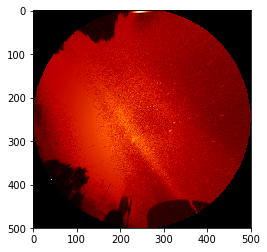

In [4]:
from mangopy import Mango

M = Mango()

site = M.get_site_info('Capitol Reef Field Station')
img, lat, lon, __ = M.get_data(site, t0)

print('ARRAY SHAPE: {}'.format(img.shape))

plt.imshow(img, cmap=plt.get_cmap('gist_heat'))

## Accessing your own data
You can use your own data by mounting it to `/home/jovyan/mount` when you create a resen bucket.  If you are running this tutorial online, the data directory `MemorialDayStorm` has already been mounted.  If you are running resen locally, you MUST have downloaded the data set from https://ingeo.datatransport.org/data/datasets/MemorialDayStorm/ and mounted it as `home/jovyan/mount/datasets/MemorialDayStorm`.

Let's read geodetic coordinates and the electron density array from the PFISR data file `20170528.001_lp_1min-fitcal.h5` using the h5py package.

In [5]:
import h5py

with h5py.File('/home/jovyan/mount/datasets/MemorialDayStorm/PFISR/20170528.001_lp_1min-fitcal.h5', 'r') as f:
    latitude = f['Geomag']['Latitude'][:]
    longitude = f['Geomag']['Longitude'][:]
    altitude = f['Geomag']['Altitude'][:]
    density = f['FittedParams']['Ne'][:]
    
print('LATITUDE ARRAY SHAPE: {}'.format(latitude.shape))
print('LONGITUDE ARRAY SHAPE: {}'.format(longitude.shape))
print('ALTITUDE ARRAY SHAPE: {}'.format(altitude.shape))
print('DENSITY ARRAY SHAPE: {}'.format(density.shape))

LATITUDE ARRAY SHAPE: (4, 17)
LONGITUDE ARRAY SHAPE: (4, 17)
ALTITUDE ARRAY SHAPE: (4, 17)
DENSITY ARRAY SHAPE: (278, 4, 17)


## Get Results
Finally, lets use Resen packages to invesgate the Memorial Day Storm data set. 

First, Let's get PFISR density profiles from the vertial and up-B beams.

In [6]:
with h5py.File('/home/jovyan/mount/datasets/MemorialDayStorm/PFISR/20170528.004_lp_1min-fitcal.h5', 'r') as f:

    # Indentify the vertical and up-B beams based on elevation angle
    elevation = f['BeamCodes'][:,2]
    z = np.argwhere(elevation-90.0<0.01)[0][0]
    b = np.argwhere(elevation-77.5<0.01)[0][0]

    # read unix time array
    utime = f['Time']['UnixTime'][:]

    # find vertical beam arrays of latitude, longitude, altitude, and density
    latz = f['Geomag']['Latitude'][z,:]
    lonz = f['Geomag']['Longitude'][z,:]
    altz = f['Geomag']['Altitude'][z,:]
    densz = f['FittedParams']['Ne'][:,z,:]

    # find up-B beam arrays of latitude, longitude, altitude, and density
    latb = f['Geomag']['Latitude'][b,:]
    lonb = f['Geomag']['Longitude'][b,:]
    altb = f['Geomag']['Altitude'][b,:]
    densb = f['FittedParams']['Ne'][:,b,:]
    

Now let's calculate the IRI electron density with pyglow at the same location of each radar bin.

In [7]:
# convert unix times to datetime object
times = [datetime.utcfromtimestamp(np.mean(tstmp)) for tstmp in utime]

iriz = []
irib = []

for t in times:
    # first do the vertical beam
    ne = []
    for lat, lon, alt in zip(latz, lonz, altz):
        pt = pyglow.Point(t, lat, lon, alt/1000.)
        pt.run_iri()
        ne.append(pt.ne*1.e6)
    iriz.append(ne)

    # next do the up-B beam
    ne = []
    for lat, lon, alt in zip(latb, lonb, altb):
        pt = pyglow.Point(t, lat, lon, alt/1000.)
        pt.run_iri()
        ne.append(pt.ne*1.e6)
    irib.append(ne)

iriz = np.array(iriz)
irib = np.array(irib)

NameError: name 'pyglow' is not defined

Now, let's try plotting both the PFISR density and the IRI density and see if there are significant differences.  First, do the vertical beam.

AttributeError: 'list' object has no attribute 'T'

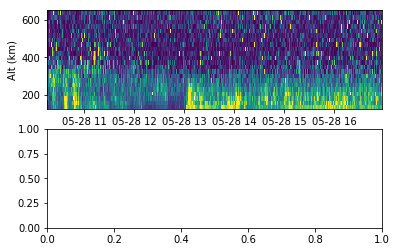

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
f = ax1.pcolormesh(times, altz/1000., densz.T, vmin=0, vmax=3e11)
ax1.set_xlabel('UT')
ax1.set_ylabel('Alt (km)')

ax2 = fig.add_subplot(212)
f = ax2.pcolormesh(times, altz/1000., iriz.T, vmin=0, vmax=3e11)
cax = fig.add_axes([0.95, 0.1, 0.05, 0.8])
ax2.set_xlabel('UT')
ax2.set_ylabel('Alt (km)')

plt.colorbar(f, cax=cax)

Now, do the up-B beam.

AttributeError: 'list' object has no attribute 'T'

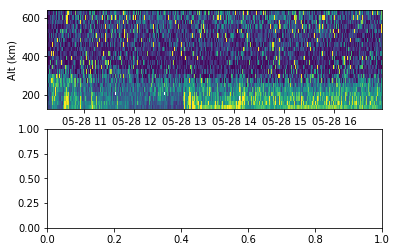

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
f = ax1.pcolormesh(times, altb/1000., densb.T, vmin=0, vmax=3e11)
ax1.set_xlabel('UT')
ax1.set_ylabel('Alt (km)')

ax2 = fig.add_subplot(212)
f = ax2.pcolormesh(times, altb/1000., irib.T, vmin=0, vmax=3e11)
ax2.set_xlabel('UT')
ax2.set_ylabel('Alt (km)')

cax = fig.add_axes([0.95, 0.1, 0.05, 0.8])
plt.colorbar(f, cax=cax)

In both the vertical and the up-B beam, IRI is significantly underestimating the electron density compared to the PFISR measurements.  One thing to validate is that coordinates along the up-B beam do in fact lie along the magnetic field line that interesects PFISR. Let's check this with apexpy.  First, calculate the geodetic coordinates of the magnetic field line.

In [10]:
A = Apex(times[0])
glat, glon, __ = A.apex2geo(pfisr_mlat, pfisr_mlon, altb/1000.)

Now, plot the coordinates of the radar beam with the coordinates of the magnetic field line and see how well they match up.

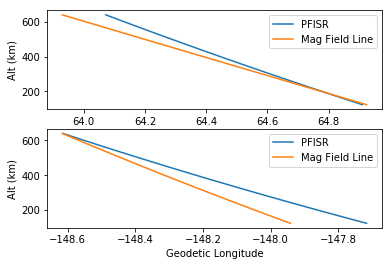

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot(latb, altb/1000., label='PFISR')
ax1.plot(glat, altb/1000., label='Mag Field Line')
ax1.set_xlabel('Geodetic Latitude')
ax1.set_ylabel('Alt (km)')
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(lonb, altb/1000., label='PFISR')
ax2.plot(glon, altb/1000., label='Mag Field Line')
ax2.set_xlabel('Geodetic Longitude')
ax2.set_ylabel('Alt (km)')
ax2.legend()

The up-B beam varies from the true magnetic field direction by less than 0.1 degrees latitude and 0.2 degrees longitude.

Now lets look at disturbances over the continential United States.  First, consider MANGO data, which is good for visualizing TIDs.

/home/jovyan/envs/py27/local/lib/python2.7/site-packages/mangopy/mosaic.py:130: RuntimeWarning: invalid value encountered in greater_equal
  flags = np.all(np.array([lon_arr>=limits[0][:,None],lon_arr<=limits[1][:,None]]),axis=0)
/home/jovyan/envs/py27/local/lib/python2.7/site-packages/mangopy/mosaic.py:130: RuntimeWarning: invalid value encountered in less_equal
  flags = np.all(np.array([lon_arr>=limits[0][:,None],lon_arr<=limits[1][:,None]]),axis=0)


Attempting to download LMay2817.h5 from FTP server.
Exception: [Errno 2] No such file or directory: '/home/jovyan/mount/datasets/MemorialDayStorm/MANGO/Millstone Hill Observatory/May2817/LMay2817.h5'
Attempting to download PMay2817.h5 from FTP server.
Exception: [Errno 2] No such file or directory: '/home/jovyan/mount/datasets/MemorialDayStorm/MANGO/Pisgah Astronomical Observatory/May2817/PMay2817.h5'
Attempting to download DMay2817.h5 from FTP server.
Exception: [Errno 2] No such file or directory: '/home/jovyan/mount/datasets/MemorialDayStorm/MANGO/McDonald Observatory/May2817/DMay2817.h5'


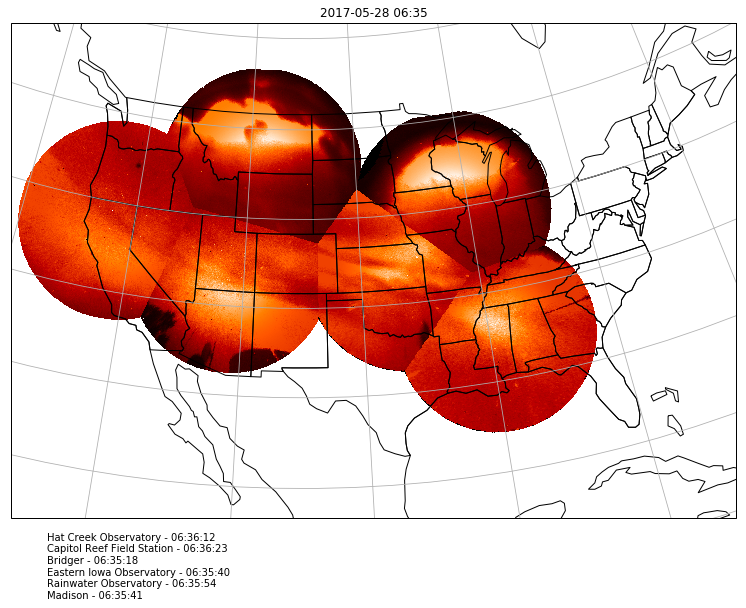

In [12]:
from mangopy import Mosaic

t0 = datetime(2017,5,28,6,35)

M = Mosaic(datadir='/home/jovyan/mount/datasets/MemorialDayStorm/MANGO')
M.plot_mosaic(t0)

We can also see how this compairs to GPS TEC contours.  This time, we'll create our own map with cartopy.  First, get the  MANGO mosaic array.

In [13]:
# get MANGO mosaic array
mosaic, __, __, mosaic_lat, mosaic_lon, __ = M.create_mosaic(t0,cell_edges=True)

Attempting to download LMay2817.h5 from FTP server.
Exception: [Errno 2] No such file or directory: '/home/jovyan/mount/datasets/MemorialDayStorm/MANGO/Millstone Hill Observatory/May2817/LMay2817.h5'
Attempting to download PMay2817.h5 from FTP server.
Exception: [Errno 2] No such file or directory: '/home/jovyan/mount/datasets/MemorialDayStorm/MANGO/Pisgah Astronomical Observatory/May2817/PMay2817.h5'
Attempting to download DMay2817.h5 from FTP server.
Exception: [Errno 2] No such file or directory: '/home/jovyan/mount/datasets/MemorialDayStorm/MANGO/McDonald Observatory/May2817/DMay2817.h5'


Then get the TEC array from the Madrigal hdf5 file.

In [14]:
# read hdf5 file to get TEC data array
with h5py.File('/home/jovyan/mount/datasets/MemorialDayStorm/gps170528g.004.hdf5','r') as f:
    tstmp = f['/Data/Array Layout/timestamps'][:]
    tec_lat = f['/Data/Array Layout/gdlat'][:]
    tec_lon = f['/Data/Array Layout/glon'][:]
    tec0 = f['/Data/Array Layout/2D Parameters/tec'][:]

# select a slice of the TEC array that is closest to t0
times = np.array([datetime.utcfromtimestamp(t) for t in tstmp])
i = np.argmin(np.abs(tstmp-(t0-datetime.utcfromtimestamp(0)).total_seconds()))
tec = tec0[:,:,i]

Finally, create a map of both parameters with cartopy.

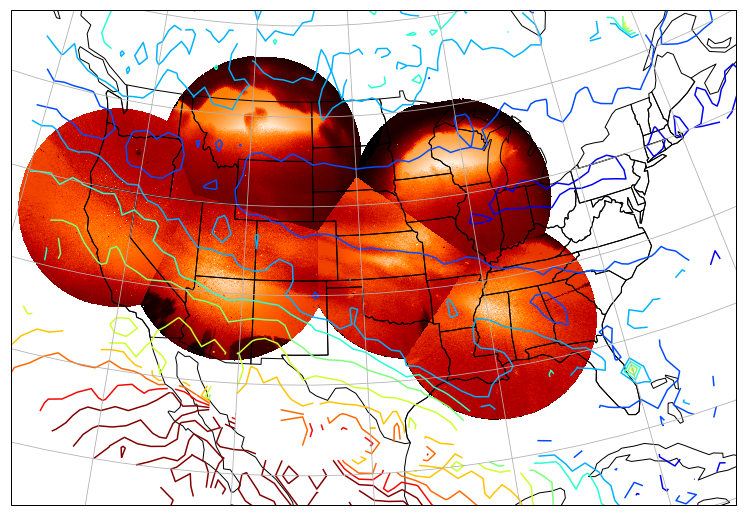

In [15]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# set up map
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111,projection=ccrs.LambertConformal(central_longitude=255.,central_latitude=40.0))
ax.coastlines()
ax.gridlines()
ax.add_feature(cfeature.STATES)
ax.set_extent([235,285,20,52])

# plot image on map
ax.pcolormesh(mosaic_lon, mosaic_lat, mosaic, cmap=plt.get_cmap('gist_heat'), transform=ccrs.PlateCarree())

ax.contour(tec_lon, tec_lat, tec, 25, vmin=0., vmax=20., cmap=plt.get_cmap('jet'), transform=ccrs.PlateCarree())

There are distinct wave features over Kansas that are aligned with the TEC contours.  Let's consider how these features evolve over time by creating keograms of redline brightness, TEC, and SuperDARN velocity at -95$^\circ$ longitude.

In [16]:
# Set a target longitude
targlon = -95.

First, extract Mango data from the Madison imager at the longitude of interest.

In [17]:
# extract MANGO data from HDF5 files
with h5py.File('/home/jovyan/mount/datasets/MemorialDayStorm/MANGO/Madison/May2817/MMay2817.h5', 'r') as f:
    tstmp = f['Time'][:]
    mango0 = f['ImageData'][:]
    mango_lat = f['Latitude'][:]
    mango_lon = f['Longitude'][:]

mango_times = np.array([datetime.utcfromtimestamp(t) for t in tstmp])
j = np.nanargmin(np.abs(mango_lon[int(mango_lon.shape[0]/2),:]-(targlon+360.)))
mango = np.ma.masked_invalid(mango0[:,j,:])

# replace nans in mango_lat
mango_lat = mango_lat[:,j]
nans = np.argwhere(np.isnan(mango_lat)).flatten()
notnans = np.argwhere(~np.isnan(mango_lat)).flatten()
mango_lat[nans]= np.interp(nans, notnans, mango_lat[notnans])

Similarly, extract the TEC values at that latitude from the TEC array previouly used.

In [18]:
# extract TEC data from TEC array previously found
j = np.argmin(np.abs(tec_lon-targlon))
tec = tec0[:,j,:]

Then, get the line-of-site velocity from beam 16 of the Fort Hayes West SuperDARN radar, which is approximatly alligned with the meridian of interest.

In [19]:
# get superDARN data along beam 16
from davitpy import pydarn

sdptr = pydarn.sdio.radDataOpen(times[0], 'fhw', eTime=times[-1], bmnum=16, src='local', fileType='fitex', local_dirfmt='/home/jovyan/mount/datasets/MemorialDayStorm/SuperDARN/')
velocity = []
sdtime = []

beam = sdptr.readRec()

# get lats
site = pydarn.radar.site(radId=beam.stid,dt=beam.time)
fov = pydarn.radar.radFov.fov(site=site,rsep=beam.prm.rsep,ngates=beam.prm.nrang,nbeams=site.maxbeam,coords='geo',date_time=beam.time)
sd_lat = fov.latCenter[16,:]

while beam is not None:
    v = np.full((beam.prm.nrang,), np.nan)
    v[beam.fit.slist] = beam.fit.v
    velocity.append(v)
    sdtime.append(beam.time)

    beam = sdptr.readRec()

velocity = np.array(velocity)
sdtime = np.array(sdtime)

ERROR:root:Could not connect to remote DB: mongodb://sd_dbread:5d@sd-work9.ece.vt.edu:27017/radarInfo


Finally, create some plots.

/home/jovyan/envs/py27/local/lib/python2.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


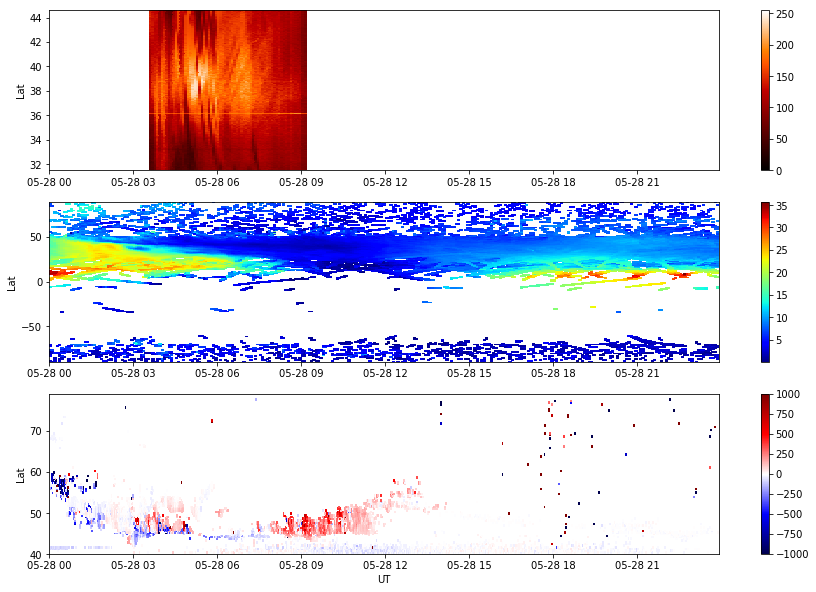

In [20]:
# Now plot

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(311)
f = ax1.pcolormesh(mango_times, mango_lat, mango.T, cmap=plt.get_cmap('gist_heat'))
ax1.set_ylabel('Lat')
plt.colorbar(f)

ax2 = fig.add_subplot(312, sharex=ax1)
f = ax2.pcolormesh(times, tec_lat, tec, cmap=plt.get_cmap('jet'))
ax2.set_ylabel('Lat')
plt.colorbar(f)

ax3 = fig.add_subplot(313, sharex=ax1)
f = ax3.pcolormesh(sdtime, sd_lat, velocity.T, cmap=plt.get_cmap('seismic'), vmin=-1000, vmax=1000.)
ax3.set_ylabel('Lat')
ax3.set_xlabel('UT')
plt.colorbar(f)